In [1]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
%matplotlib inline

# Decision Tree (决策树)

决策树与数据结构中的"树"相同,每个节点代表特征并基于此继续划分其他特征，直到此节点下的所有类都是同一类，如下图所示：
![](./imgs/struct.png)

经过训练后的决策树模型可以清楚的知道模型在预测时对各个特征的取舍，让人类能轻易理解。决策树与knn不同，他是需要经过训练的，其训练最大的问题时如何划分特征？选择哪个特征作为优先划分？

我们有个判断好瓜与坏瓜的数据集，每个瓜有两个特征，分别为软硬以及大小，如下所示：

| 编号 | 软硬 | 大小 | 标签 |
| :--: | :--: | :--: | :--: |
| 1 | 硬 | 大 | 好瓜 |
| 2 | 软 | 大 | 坏瓜 |
| 3 | 软 | 小 | 好瓜 |
| 4 | 软 | 小 | 坏瓜 |
| 5 | 硬 | 大 | 好瓜 |

训练的时候，会根据数据的分布将数据一步一步的划分，简单来说，我们的目的是把原始的数据划分成两边的较相似的数据，例如老师收到一个成绩单，有100位同学的是否及格以及男女，老师想判断同学的学习优劣最简单的方法就是以及格位特征一刀切分成两边较相似的数据，而不是划分男女。然而现实的数据不像考试成绩这么直白，我们可以利用信息论的算法来测量切割前后的数据纯度，而切割前后提升的纯度我们称为信息增益(information gain)，信息增益最多的特征就是首先划分的特征。

首先，我们先介绍熵(entrophy)的概念，熵来自热力学第二定律，熵越大代表混乱程度越高，举例来说，泡拿铁的时候，我们将牛奶倒进咖啡里，一开始白色的牛奶和黑色的咖啡分明，此时熵最低，但是没过一会儿，就变成咖啡色的拿铁，这时代表最高的混乱程度，也就是熵变高了。信息熵就是衡量一个分布的纯度的一个变量，可以理解为比较不可能发生的事情，当它发生了，会提供更多的信息，他的公式就是信息的期望值，首先信息的计算如下表示：
$$log_2p(x_i)$$
$p(x_i)$是选择这个class_i的概率值，而期望如下所示：
$$-\sum_{i=1}^{n}p(x_i))log_2p(x_i)$$




### 优缺点

优点：计算资源少、容易从数据提取关键点、对缺失数据不敏感  
缺点：容易过拟合

### 示例代码
以判断好瓜与坏瓜为例

第一个函数：产生数据集  
第二个函数：计算数据集的信息熵

In [2]:
def createDataSet():
    dataSet = [[1, 1, 'good'],
               [0, 1, 'bad'],
               [0, 0, 'good'],
               [0, 0, 'bad'],
               [1, 1, 'good']]
    labels = ['soft','thick']
    
    return dataSet, labels

def calcShannonEnt(dataSet):
    numEntries = len(dataSet)
    labelCounts = {}
    for featVec in dataSet: #the the number of unique elements and their occurance
        currentLabel = featVec[-1]
        labelCounts[currentLabel] = labelCounts.get(currentLabel,0)+1
    shannonEnt = 0.0
    for key in labelCounts:
        prob = labelCounts[key]/numEntries
        shannonEnt -= prob * np.log2(prob)
    return shannonEnt

In [3]:
myData, labels = createDataSet()
myData, calcShannonEnt(myData)

([[1, 1, 'good'],
  [0, 1, 'bad'],
  [0, 0, 'good'],
  [0, 0, 'bad'],
  [1, 1, 'good']],
 0.9709505944546686)

切分数据  
dataSet：数据集  
axis：要切分的特征所代表的index  
value：根据特征的什么值来切分

In [4]:
def splitDataSet(dataSet, axis, value): # dataSet, feature to split, feature value
    retDataSet = []
    for featVec in dataSet:
        if featVec[axis] == value:
            reducedFeatVec = featVec[:axis] + featVec[axis+1:]
            retDataSet.append(reducedFeatVec)
    return retDataSet
splitDataSet(myData,1,1)

[[1, 'good'], [0, 'bad'], [1, 'good']]

对每个特征的每种可能出现的数值进行信息增益计算，回传信息增益最大的特征的index

In [5]:
def chooseBestFeatureToSplit(dataSet):
    numFeatures = len(dataSet[0]) - 1      # the last column is used for the labels
    baseEntropy = calcShannonEnt(dataSet)
    bestInfoGain = 0.0; bestFeature = -1
    for i in range(numFeatures):        # iterate over all the features
        featList = [sample[i] for sample in dataSet] # create a list of all the examples of this feature
        uniqueVals = set(featList)       # get a set of unique values
        newEntropy = 0.0
        for value in uniqueVals:
            subDataSet = splitDataSet(dataSet, i, value)
            ratio = len(subDataSet)/len(dataSet)
            newEntropy += ratio * calcShannonEnt(subDataSet)     
        infoGain = baseEntropy - newEntropy     # calculate the info gain; ie reduction in entropy
        if (infoGain > bestInfoGain):       # compare this to the best gain so far
            bestInfoGain = infoGain         # if better than current best, set to best
            bestFeature = i
    return bestFeature                      # returns an integer
chooseBestFeatureToSplit(myData)

0

第一个函数：选择枝叶下占多数的class  
第二个函数：根据上述的函数创建决策树  

In [6]:
def majorityCnt(classList):
    classCount={}
    for vote in classList:
        classCount[vote] = classCount.get(vote,0)+1
    sortedClassCount = sorted(classCount.items(), key=lambda x:x[1], reverse=True)
    return sortedClassCount[0][0]

def createTree(dataSet,labels):
    classList = [sample[-1] for sample in dataSet]
    if classList.count(classList[0]) == len(classList): 
        return classList[0] # stop splitting when all of the classes are equal
    if len(dataSet[0]) == 1: # stop splitting when there are no more features in dataSet
        return majorityCnt(classList)
    bestFeat = chooseBestFeatureToSplit(dataSet)
    bestFeatLabel = labels[bestFeat]
    myTree = {bestFeatLabel:{}}
    del(labels[bestFeat])
    featValues = [example[bestFeat] for example in dataSet]
    uniqueVals = set(featValues)
    for value in uniqueVals:
        subLabels = labels[:]       # copy all of labels, so trees don't mess up existing labels
        myTree[bestFeatLabel][value] = createTree(splitDataSet(dataSet, bestFeat, value),subLabels)
    return myTree  

tree = createTree(myData.copy(), labels.copy())

画树

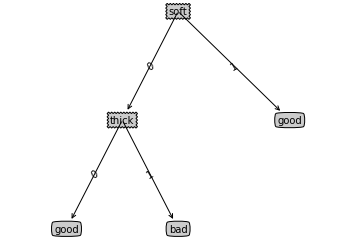

In [7]:
decisionNode = dict(boxstyle="sawtooth", fc="0.8")
leafNode = dict(boxstyle="round4", fc="0.8")
arrow_args = dict(arrowstyle="<-")

def getNumLeafs(myTree):
    numLeafs = 0
    firstStr = list(myTree.keys())[0]
    secondDict = myTree[firstStr]
    for key in secondDict.keys():
        if type(secondDict[key]).__name__=='dict':#test to see if the nodes are dictonaires, if not they are leaf nodes
            numLeafs += getNumLeafs(secondDict[key])
        else:   numLeafs +=1
    return numLeafs

def getTreeDepth(myTree):
    maxDepth = 0
    firstStr = list(myTree.keys())[0]
    secondDict = myTree[firstStr]
    for key in secondDict.keys():
        if type(secondDict[key]).__name__=='dict':#test to see if the nodes are dictonaires, if not they are leaf nodes
            thisDepth = 1 + getTreeDepth(secondDict[key])
        else:   thisDepth = 1
        if thisDepth > maxDepth: maxDepth = thisDepth
    return maxDepth

def plotNode(nodeTxt, centerPt, parentPt, nodeType):
    createPlot.ax1.annotate(nodeTxt, xy=parentPt,  xycoords='axes fraction',
             xytext=centerPt, textcoords='axes fraction',
             va="center", ha="center", bbox=nodeType, arrowprops=arrow_args )
    
def plotMidText(cntrPt, parentPt, txtString):
    xMid = (parentPt[0]-cntrPt[0])/2.0 + cntrPt[0]
    yMid = (parentPt[1]-cntrPt[1])/2.0 + cntrPt[1]
    createPlot.ax1.text(xMid, yMid, txtString, va="center", ha="center", rotation=30)

def plotTree(myTree, parentPt, nodeTxt):#if the first key tells you what feat was split on
    numLeafs = getNumLeafs(myTree)  #this determines the x width of this tree
    depth = getTreeDepth(myTree)
    firstStr = list(myTree.keys())[0]     #the text label for this node should be this
    cntrPt = (plotTree.xOff + (1.0 + float(numLeafs))/2.0/plotTree.totalW, plotTree.yOff)
    plotMidText(cntrPt, parentPt, nodeTxt)
    plotNode(firstStr, cntrPt, parentPt, decisionNode)
    secondDict = myTree[firstStr]
    plotTree.yOff = plotTree.yOff - 1.0/plotTree.totalD
    for key in secondDict.keys():
        if type(secondDict[key]).__name__=='dict':#test to see if the nodes are dictonaires, if not they are leaf nodes   
            plotTree(secondDict[key],cntrPt,str(key))        #recursion
        else:   #it's a leaf node print the leaf node
            plotTree.xOff = plotTree.xOff + 1.0/plotTree.totalW
            plotNode(secondDict[key], (plotTree.xOff, plotTree.yOff), cntrPt, leafNode)
            plotMidText((plotTree.xOff, plotTree.yOff), cntrPt, str(key))
    plotTree.yOff = plotTree.yOff + 1.0/plotTree.totalD
#if you do get a dictonary you know it's a tree, and the first element will be another dict

def createPlot(inTree):
    fig = plt.figure(1, facecolor='white')
    fig.clf()
    axprops = dict(xticks=[], yticks=[])
    createPlot.ax1 = plt.subplot(111, frameon=False, **axprops)    #no ticks
    #createPlot.ax1 = plt.subplot(111, frameon=False) #ticks for demo puropses 
    plotTree.totalW = float(getNumLeafs(inTree))
    plotTree.totalD = float(getTreeDepth(inTree))
    plotTree.xOff = -0.5/plotTree.totalW; plotTree.yOff = 1.0;
    plotTree(inTree, (0.5,1.0), '')
    plt.show()

def retrieveTree(i):
    listOfTrees =[{'no surfacing': {0: 'no', 1: {'flippers': {0: 'no', 1: 'yes'}}}},
                  {'no surfacing': {0: 'no', 1: {'flippers': {0: {'head': {0: 'no', 1: 'yes'}}, 1: 'no'}}}}
                  ]
    return listOfTrees[i]

createPlot(tree)

In [8]:
def classify(inputTree,featLabels,testVec):
    firstStr = list(inputTree.keys())[0]
    secondDict = inputTree[firstStr]
    featIndex = featLabels.index(firstStr)
    key = testVec[featIndex]
    valueOfFeat = secondDict[key]
    if isinstance(valueOfFeat, dict): 
        classLabel = classify(valueOfFeat, featLabels, testVec)
    else: classLabel = valueOfFeat
    return classLabel

classify(tree, labels, [0,1])

'bad'